In [1]:
import os,sys
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## First we need to define some things. user/passwd, etc.

In [2]:
targetNumDates = 3 #may be able to increase this if you are using less than a full frame (<9-10 bursts, <3 swaths)
username ='rlohman'
passwd   =''
workdir  ='Oman' #make sure this exists
dem      = '/home/jovyan/Oman/DEM/demLat_N18_N21_Lon_E055_E058.dem.wgs84' #make sure this exists too!

## Fix Paths
Do this if you haven't already - will have to close and restart this notebook.

## Go to vertex and do an initial search
You should narrow down your area of interest, and which track you are using. Choose a bounding box (draw on map) - all frames that even touch it will be downloaded, so take some care in choosing a reasonable bounds
Paste in the "wkt" format lat/lon bounds from vertex, and set your track and other info below.

In [ ]:
polygon = "&intersectsWith=POLYGON((55.4286 18.7125,57.4812 19.0657,57.3074 20.0412,55.1998 19.6171,55.4286 18.7125))"
track   = "&relativeOrbit=130" #also referred to as "relative orbit"
date1   = '&start=2018-05-01'  #start of search date period
date2   = '&end=2018-10-01'    #end of search date period
refdate = '20180502'
pltdate = '20180514_20180526' #pair that you will plot in a later step

narrowpoly = ' -b \'18.33 20.43 54.95 57.55\' ' #this is the area you want to extract, but may need be adjusted after your first iter of stackSentinel_VH
swaths     = ' -n \'1 2 3\''    #list of swaths if you know you only need one or two, otherwise all.
looks      = ' -r 20 -z 4 ' #final looks of your large-area interferograms
croppoly   = [2000, 4000, 28000, 3000]

## Run api calls to construct list of files

In [4]:
#this is a dumb way of doing this, but I don't feel like dealing with installing the requests package.
apistring='https://api.daac.asf.alaska.edu/services/search/param?platform=S1&beamSwath=IW&processingLevel=SLC'+track+date1+date2+polygon
os.system('wget \"'+apistring+'&output=csv\" -O list.csv -q')


0

In [5]:
df = pandas.read_csv('list.csv')
df['Acquisition Date'] = pandas.to_datetime(df['Acquisition Date'])
df['date'] = pandas.to_datetime(df['Acquisition Date'])    
numfiles = np.shape(df)[0]

uniqueDates=df['date'].dt.date.unique()
uniqueDates.sort()
totNumDates=np.size(uniqueDates)
batches = int(np.ceil(totNumDates / targetNumDates))
print("running in "+ str(batches) + " batches with "+ str(totNumDates)+ ' unique dates and ' + str(numfiles) +' total files')


running in 5 batches with 13 unique dates and 13 total files


## First batch
Now we have a list of files so we will try our first batch, which should contain your first (reference) date as set above.  I think this SHOULD now find all files on a given date.  That part was a pain.

In [ ]:
index=0
i=0
print('Downloading data for batch '+str(int(i)))
for j in np.arange(targetNumDates):
    if index < totNumDates:
        for k in np.arange(numfiles):
             if df.date[k].date() == uniqueDates[index]:
                    rawFile=df['URL'][k]
                    rawRoot=os.path.basename(rawFile)
                    if os.path.exists(os.path.join('/home/jovyan',workdir,'raw',rawRoot)):
                        print(rawRoot+' already downloaded')
                    else:
                        print('Downloading '+rawRoot)
                        wstr='wget '+ rawFile+ ' --user="' + username + '" --password="' + passwd + '" --directory-prefix=' + workdir + '/raw'
                        os.system(wstr+'-q  --progress=bar:force:noscroll')
        index+=1
    

## prepping and running stack

In [7]:
command='/home/jovyan/stackSentinel_VH.py -s /home/jovyan/'+workdir+'/raw -m '+refdate+' -o /home/jovyan/ -a /home/jovyan/'+workdir+'/aux/ -w /home/jovyan/'+workdir+' -d '+dem+narrowpoly+swaths+looks+' -c 1 -O 1 -W interferogram'
os.system(command)

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce

**************************
run_files folder exists.
/home/jovyan/Oman/run_files  already exists.
Please remove or rename this folder and try again.

**************************


256

## Check output 
Did it run and make run_files and runstuff and runstuff2?  Did all the dates get selected?  often need to adjust the -b parameter here.

In [ ]:
os.system('/home/jovyan/'+workdir+'/runstuff  > errors 2> extraerrors')

## Check output
Did everything run?  Is there content in the merged directory?  If so, now is the time to pick your cropping locations.

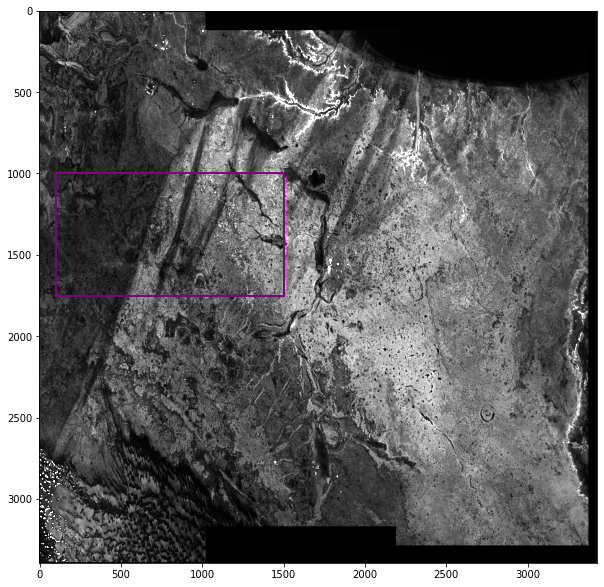

In [8]:
#bounds of our cropped region
x1=int(croppoly[0]/20)
x2=int((croppoly[0]+croppoly[2])/20)
y1=int(croppoly[1]/4)
y2=int((croppoly[1]+croppoly[3])/4)

ds = gdal.Open("/home/jovyan/Oman/merged/interferograms/"+pltdate+"/fine.int", gdal.GA_ReadOnly)
data_array = ds.GetRasterBand(1).ReadAsArray()

ang_data_array= np.angle(data_array)
abs_data_array= np.abs(data_array)
plt.figure(figsize=(10, 11))
#plt.imshow(ang_data_array,vmin=-np.pi, vmax=np.pi, cmap='jet')
plt.imshow(abs_data_array,vmin=0, vmax=10000, cmap='gray')
rect=mpatches.Rectangle((x1,y1),(x2-x1),(y2-y1), 
                        fill=False,
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)

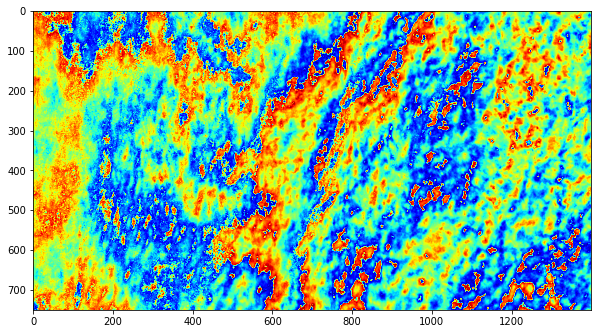

In [9]:
plt.figure(figsize=(10, 11))
plt.imshow(ang_data_array[y1:y2,x1:x2],vmin=-np.pi, vmax=np.pi, cmap='jet')

## Crop and delete
Next we run runstuff 2 - be careful, since what it does is crop and then delete files!

In [ ]:
os.system('/home/jovyan/'+workdir+'/runstuff2')os.rename('/home/jovyan/'+workdir+'/run_files','/home/jovyan/'+workdir+'/run_files'+str(i))

In [ ]:
#move old runfiles+errors to a new directory
os.rename('/home/jovyan/'+workdir+'/runstuff','/home/jovyan/'+workdir+'/run_files'+str(i)+'/runstuff')
os.remove('/home/jovyan/'+workdir+'/runstuff2','/home/jovyan/'+workdir+'/run_files'+str(i)+'/runstuff2')

## If you are content with what comes out, let's run the rest of the batches.

In [ ]:
for i in np.arange(i+1,batches):
    print('Starting batch '+str(int(i)))
    for j in np.arange(targetNumDates):
        if index < totNumDates:
            for k in np.arange(numfiles):
                 if df.date[k].date() == uniqueDates[index]:
                    rawFile=df['URL'][k]
                    rawRoot=os.path.basename(rawFile)
                    if os.path.exists(os.path.join('/home/jovyan',workdir,'raw',rawRoot)):
                        print(rawRoot+' already downloaded')
                    else:
                        print('Downloading '+rawRoot)
                        wstr='wget '+ rawFile+ ' --user="' + username + '" --password="' + passwd + '" --directory-prefix=' + workdir + '/raw'
                        os.system(wstr+' --progress=bar:force:noscroll')
 
            index+=1
    
    command='/home/jovyan/stackSentinel_VH.py -s /home/jovyan/'+workdir+'/raw -m '+refdate+' -o /home/jovyan/ -a /home/jovyan/'+workdir+'/aux/ -w /home/jovyan/'+workdir+' -d '+dem+narrowpoly+swaths+looks+' -c 1 -O 1 -W interferogram'
    os.system(command)
    os.system('/home/jovyan/'+workdir+'/runstuff  > errors 2> extraerrors')
    os.system('/home/jovyan/'+workdir+'/runstuff2')
    os.rename('/home/jovyan/'+workdir+'/run_files','/home/jovyan/'+workdir+'/run_files'+str(i))
    os.rename('/home/jovyan/'+workdir+'/runstuff','/home/jovyan/'+workdir+'/run_files'+str(i)+'/runstuff')
    os.remove('/home/jovyan/'+workdir+'/runstuff2','/home/jovyan/'+workdir+'/run_files'+str(i)+'/runstuff2')